In [3]:
# Standard imports
import os
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Any, Dict, List, Optional, Tuple, Union, Generator

# Data handling
import datasets
from datasets import Features, Sequence, Value
from gluonts.ev.metrics import MSE, MAE

# Machine learning
import torch
import lightning as L
from sklearn.preprocessing import StandardScaler

# uni2ts imports
from uni2ts.model.moirai import MoiraiModule, MoiraiForecast, MoiraiFinetune
from uni2ts.distribution import StudentTOutput, NormalOutput, MixtureOutput
from uni2ts.loss.packed import PackedNLLLoss
from uni2ts.data.loader import DataLoader, PackCollate
from uni2ts.eval_util.metrics import MedianMSE
from uni2ts.eval_util.plot import plot_single

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [8]:
def extract_sp500_data(start_year=2008, end_year=2015):
    """Extract SP500 close price data from the Parquet data lake."""
    # Construct the path pattern - note the format of month=01, month=02, etc.
    path_pattern = f"/home/dev/data/ohlcv/asset_class=index/freq=1d/symbol=SPX/year=*/month=*/part.parquet"
    
    print(f"Attempting to load data from: {path_pattern}")
    
    # Scan the parquet files
    scan = pl.scan_parquet(
        path_pattern,
        hive_partitioning=True,
    )
    
    # Filter for the specific years we want
    scan = scan.filter(
        (pl.col("year") >= start_year) & (pl.col("year") <= end_year)
    )
    
    # Select only timestamp and close price
    df = scan.select(
        pl.col("ts"),
        pl.col("close"),
    ).sort("ts").collect()
    
    return df

# Extract SP500 data
sp500_data = extract_sp500_data(start_year=2008, end_year=2015)
print(f"Loaded {len(sp500_data)} data points")
sp500_data.head()


Attempting to load data from: /home/dev/data/ohlcv/asset_class=index/freq=1d/symbol=SPX/year=*/month=*/part.parquet
Loaded 2015 data points


ts,close
"datetime[μs, UTC]",f64
2008-01-02 05:00:00 UTC,1447.16
2008-01-03 05:00:00 UTC,1447.16
2008-01-04 05:00:00 UTC,1411.63
2008-01-07 05:00:00 UTC,1416.18
2008-01-08 05:00:00 UTC,1390.19


Missing values: close    0
dtype: int64
Normalization parameters - Mean: 1448.865781637717, Std: 380.9396525634451


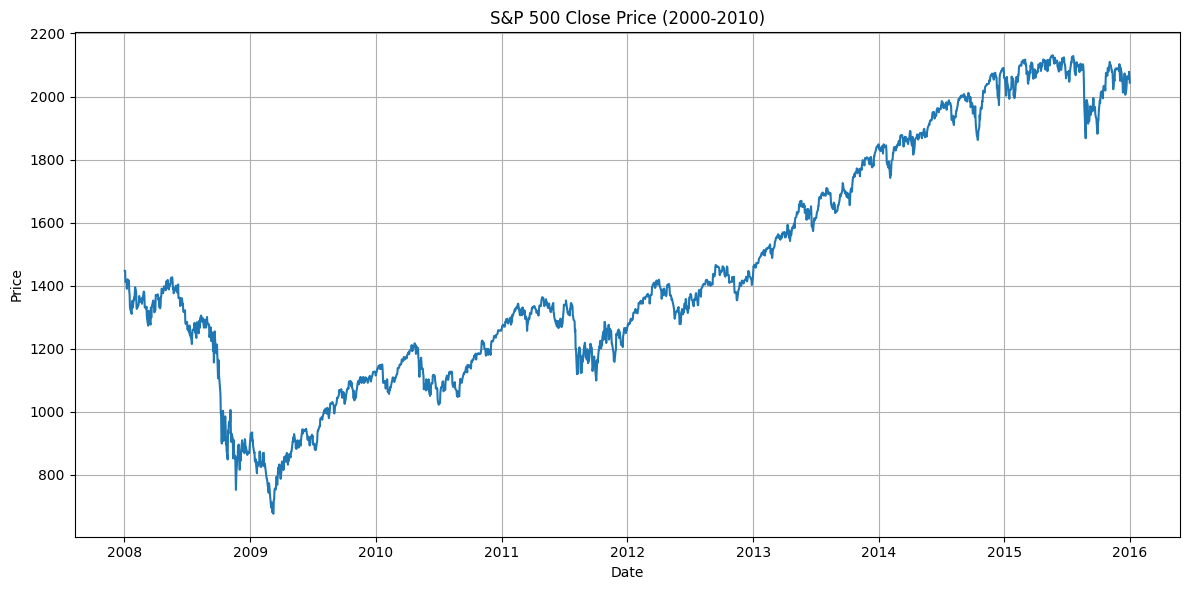

In [9]:
# Convert to pandas for easier manipulation
sp500_df = sp500_data.to_pandas()
sp500_df.set_index('ts', inplace=True)

# Check for missing values
print(f"Missing values: {sp500_df.isnull().sum()}")

# Handle missing values if any
if sp500_df.isnull().sum().sum() > 0:
    # Forward fill with a limit of 3 days
    sp500_df = sp500_df.fillna(method='ffill', limit=3)
    # Drop any remaining nulls
    sp500_df = sp500_df.dropna()

# Normalize the data
scaler = StandardScaler()
sp500_df_norm = pd.DataFrame(
    scaler.fit_transform(sp500_df),
    index=sp500_df.index,
    columns=sp500_df.columns
)

# Store normalization parameters for later use
norm_mean = scaler.mean_[0]
norm_std = scaler.scale_[0]
print(f"Normalization parameters - Mean: {norm_mean}, Std: {norm_std}")

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(sp500_df.index, sp500_df['close'])
plt.title('S&P 500 Close Price (2000-2010)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
def create_univariate_dataset(df):
    """Create a univariate dataset for the MOIRAI model."""
    def example_gen_func() -> Generator[dict[str, Any], None, None]:
        yield {
            "target": df["close"].to_numpy(),  # array of shape (time,)
            "start": df.index[0],
            "freq": pd.infer_freq(df.index),
            "item_id": "SPX",
        }
    
    features = Features(
        dict(
            target=Sequence(Value("float32")),
            start=Value("timestamp[s]"),
            freq=Value("string"),
            item_id=Value("string"),
        )
    )
    
    hf_dataset = datasets.Dataset.from_generator(example_gen_func, features=features)
    return hf_dataset

# Create the dataset
sp500_dataset = create_univariate_dataset(sp500_df_norm)
print(sp500_dataset)

# Split into train/val/test
train_size = int(0.7 * len(sp500_df_norm))
val_size = int(0.15 * len(sp500_df_norm))
test_size = len(sp500_df_norm) - train_size - val_size

# Create datasets for each split
train_df = sp500_df_norm.iloc[:train_size]
val_df = sp500_df_norm.iloc[train_size:train_size+val_size]
test_df = sp500_df_norm.iloc[train_size+val_size:]

train_dataset = create_univariate_dataset(train_df)
val_dataset = create_univariate_dataset(val_df)
test_dataset = create_univariate_dataset(test_df)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['target', 'start', 'freq', 'item_id'],
    num_rows: 1
})


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Train: 1410, Val: 302, Test: 303


In [ ]:
def configure_moirai_model(pretrained_model_name="Salesforce/moirai-1.1-R-base"):
    """Configure the MOIRAI model for financial time series forecasting."""
    # Load the pretrained model
    module = MoiraiModule.from_pretrained(pretrained_model_name)
    
    # Configure the model for financial time series
    forecast_config = {
        "context_length": 256,  # Number of time steps to use as context
        "prediction_length": 30,  # Number of time steps to predict
        "patch_size": 16,  # Patch size for the transformer (or "auto")
        "num_samples": 100,  # Number of samples for evaluation
    }
    
    # Create a forecast model for inference
    forecast_model = MoiraiForecast(
        module=module,
        prediction_length=forecast_config["prediction_length"],
        context_length=forecast_config["context_length"],
        patch_size=forecast_config["patch_size"],
        num_samples=forecast_config["num_samples"],
        target_dim=1,  # For univariate SP500 close price
        feat_dynamic_real_dim=0,  # No additional features for now
        past_feat_dynamic_real_dim=0,  # No past-only features for now
    )
    
    return forecast_model, forecast_config

# Configure the model
model, config = configure_moirai_model()
print(f"Model configured with context length: {config['context_length']}, prediction length: {config['prediction_length']}")


Model configured with context length: 256, prediction length: 30


In [22]:
def train_moirai_model(forecast_model, train_dataset, val_dataset, context_length=256, prediction_length=30, epochs=10, batch_size=32, learning_rate=1e-4):
    """Fine-tune the MOIRAI model on financial time series data."""
    # Set up optimizer
    optimizer = torch.optim.AdamW(forecast_model.module.parameters(), lr=learning_rate)
    
    # Training loop
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    forecast_model.module = forecast_model.module.to(device)
    
    # Move to training mode
    forecast_model.module.train()
    
    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0
        
        # Process each sample in the training dataset
        for i in range(0, len(train_dataset), batch_size):
            batch_indices = range(i, min(i + batch_size, len(train_dataset)))
            batch_size_actual = len(batch_indices)
            
            # Prepare batch data
            past_targets = []
            future_targets = []
            
            for idx in batch_indices:
                sample = train_dataset[idx]
                target = torch.tensor(sample["target"], dtype=torch.float32)
                
                # Split into past and future
                if len(target) >= context_length + prediction_length:
                    past = target[:context_length]
                    future = target[context_length:context_length + prediction_length]
                else:
                    # If sample is too short, pad it
                    if len(target) < context_length:
                        padding = torch.zeros(context_length - len(target))
                        past = torch.cat([target, padding])
                    else:
                        past = target[:context_length]
                    
                    if len(target) < context_length + prediction_length:
                        future_len = max(0, len(target) - context_length)
                        future = target[context_length:context_length + future_len]
                        padding = torch.zeros(prediction_length - future_len)
                        future = torch.cat([future, padding])
                    else:
                        future = target[context_length:context_length + prediction_length]
                
                past_targets.append(past)
                future_targets.append(future)
            
            # Stack batch data
            past_targets = torch.stack(past_targets).to(device)
            future_targets = torch.stack(future_targets).to(device)
            
            # Create observed masks (all True for simplicity)
            past_observed = torch.ones_like(past_targets, dtype=torch.bool).to(device)
            future_observed = torch.ones_like(future_targets, dtype=torch.bool).to(device)
            
            # Add batch dimension if needed
            if past_targets.dim() == 2:  # [batch, time]
                past_targets = past_targets.unsqueeze(-1)  # [batch, time, 1]
                future_targets = future_targets.unsqueeze(-1)  # [batch, time, 1]
                past_observed = past_observed.unsqueeze(-1)  # [batch, time, 1]
                future_observed = future_observed.unsqueeze(-1)  # [batch, time, 1]
            
            # Create past_is_pad (all False for simplicity)
            past_is_pad = torch.zeros_like(past_targets, dtype=torch.bool).squeeze(-1).to(device)
            
            # Forward pass
            optimizer.zero_grad()
            distr = forecast_model(
                past_target=past_targets,
                past_observed_target=past_observed,
                past_is_pad=past_is_pad,
            )
            
            # Calculate loss
            loss = PackedNLLLoss()(distr, future_targets, future_observed)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
        
        # Print epoch statistics
        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        
        # Validation
        if val_dataset:
            forecast_model.module.eval()
            val_loss = 0.0
            val_batches = 0
            
            with torch.no_grad():
                for i in range(0, len(val_dataset), batch_size):
                    batch_indices = range(i, min(i + batch_size, len(val_dataset)))
                    batch_size_actual = len(batch_indices)
                    
                    # Prepare batch data (similar to training)
                    past_targets = []
                    future_targets = []
                    
                    for idx in batch_indices:
                        sample = val_dataset[idx]
                        target = torch.tensor(sample["target"], dtype=torch.float32)
                        
                        # Split into past and future (same logic as training)
                        if len(target) >= context_length + prediction_length:
                            past = target[:context_length]
                            future = target[context_length:context_length + prediction_length]
                        else:
                            # If sample is too short, pad it
                            if len(target) < context_length:
                                padding = torch.zeros(context_length - len(target))
                                past = torch.cat([target, padding])
                            else:
                                past = target[:context_length]
                            
                            if len(target) < context_length + prediction_length:
                                future_len = max(0, len(target) - context_length)
                                future = target[context_length:context_length + future_len]
                                padding = torch.zeros(prediction_length - future_len)
                                future = torch.cat([future, padding])
                            else:
                                future = target[context_length:context_length + prediction_length]
                        
                        past_targets.append(past)
                        future_targets.append(future)
                    
                    # Stack batch data
                    past_targets = torch.stack(past_targets).to(device)
                    future_targets = torch.stack(future_targets).to(device)
                    
                    # Create observed masks (all True for simplicity)
                    past_observed = torch.ones_like(past_targets, dtype=torch.bool).to(device)
                    future_observed = torch.ones_like(future_targets, dtype=torch.bool).to(device)
                    
                    # Add batch dimension if needed
                    if past_targets.dim() == 2:  # [batch, time]
                        past_targets = past_targets.unsqueeze(-1)  # [batch, time, 1]
                        future_targets = future_targets.unsqueeze(-1)  # [batch, time, 1]
                        past_observed = past_observed.unsqueeze(-1)  # [batch, time, 1]
                        future_observed = future_observed.unsqueeze(-1)  # [batch, time, 1]
                    
                    # Create past_is_pad (all False for simplicity)
                    past_is_pad = torch.zeros_like(past_targets, dtype=torch.bool).squeeze(-1).to(device)
                    
                    # Forward pass
                    distr = forecast_model(
                        past_target=past_targets,
                        past_observed_target=past_observed,
                        past_is_pad=past_is_pad,
                    )
                    
                    # Calculate loss
                    loss = PackedNLLLoss()(distr, future_targets, future_observed)
                    
                    val_loss += loss.item()
                    val_batches += 1
            
            # Print validation statistics
            avg_val_loss = val_loss / val_batches
            print(f"Validation Loss: {avg_val_loss:.4f}")
            
            # Set back to training mode
            forecast_model.module.train()
    
    return forecast_model.module

# Train the model
trained_module = train_moirai_model(
    forecast_model=model,  # This is the MoiraiForecast model from the previous cell
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    context_length=config["context_length"],  # Pass the context_length from config
    prediction_length=config["prediction_length"],  # Pass the prediction_length from config
    epochs=5,  # Start with a small number for testing
    batch_size=16,
    learning_rate=1e-4,
)

print("Training completed")


AttributeError: 'Tensor' object has no attribute 'log_prob'

In [ ]:
def evaluate_model(module, test_dataset, config):
    """Evaluate the MOIRAI model on test data."""
    # Create a forecast model for evaluation
    forecast_model = MoiraiForecast(
        module=module,
        prediction_length=config["prediction_length"],
        context_length=config["context_length"],
        patch_size=config["patch_size"],
        num_samples=config["num_samples"],
        target_dim=1,  # For univariate SP500 close price
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )
    
    # Create a predictor
    predictor = forecast_model.create_predictor(batch_size=1)
    
    # Create test loader for GluonTS evaluation
    from gluonts.dataset.split import TestData
    from gluonts.ev.metrics import MSE, MAE
    
    # Convert test_dataset to GluonTS format
    test_entries = []
    for i in range(len(test_dataset)):
        sample = test_dataset[i]
        test_entries.append({
            "target": sample["target"],
            "start": sample["start"],
            "item_id": sample.get("item_id", f"ts_{i}"),
        })
    
    # Create TestData object
    test_data = TestData(
        input=[{
            "target": entry["target"][:-config["prediction_length"]],
            "start": entry["start"],
            "item_id": entry["item_id"],
        } for entry in test_entries],
        label=[{
            "target": entry["target"][-config["prediction_length"]:],
            "start": entry["start"] + len(entry["target"]) - config["prediction_length"],
            "item_id": entry["item_id"],
        } for entry in test_entries],
    )
    
    # Generate forecasts
    forecasts = predictor.predict(test_data.input)
    
    # Evaluate using GluonTS metrics
    from uni2ts.eval_util.metrics import MedianMSE
    
    # Use MedianMSE from uni2ts and MSE/MAE from gluonts
    metrics = [MedianMSE(), MSE(), MAE()]
    
    # Evaluate forecasts
    from uni2ts.eval_util.evaluation import evaluate_forecasts
    
    results = evaluate_forecasts(
        forecasts=forecasts,
        test_data=test_data,
        metrics=metrics,
    )
    
    print(f"Evaluation results:\n{results}")
    
    # Get a sample forecast for visualization
    sample_input = test_data.input[0]
    sample_label = test_data.label[0]
    sample_forecast = next(predictor.predict([sample_input]))
    
    # Denormalize the data for plotting
    target_denorm = sample_input["target"] * norm_std + norm_mean
    label_denorm = sample_label["target"] * norm_std + norm_mean
    forecast_samples_denorm = sample_forecast.samples * norm_std + norm_mean
    
    # Plot the forecast
    plt.figure(figsize=(12, 6))
    
    # Plot historical data
    plt.plot(
        range(len(target_denorm)),
        target_denorm,
        label="Historical",
        color="blue",
    )
    
    # Plot actual future data
    plt.plot(
        range(len(target_denorm), len(target_denorm) + len(label_denorm)),
        label_denorm,
        label="Actual",
        color="green",
    )
    
    # Plot the median forecast
    forecast_median = np.median(forecast_samples_denorm, axis=0)
    plt.plot(
        range(len(target_denorm), len(target_denorm) + len(forecast_median)),
        forecast_median,
        label="Median Forecast",
        color="red",
    )
    
    # Plot the 90% confidence interval
    plt.fill_between(
        range(len(target_denorm), len(target_denorm) + len(forecast_median)),
        np.percentile(forecast_samples_denorm, 5, axis=0),
        np.percentile(forecast_samples_denorm, 95, axis=0),
        alpha=0.3,
        color="red",
        label="90% Confidence Interval",
    )
    
    plt.axvline(x=len(target_denorm), color="black", linestyle="--")
    plt.title("SP500 Close Price Forecast")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return results

# Evaluate the model
evaluation_results = evaluate_model(trained_module, test_dataset, config)
